In [1]:
from eda_import import *
import pysam

In [2]:
print(datetime.datetime.today())

2018-05-09 09:18:43.001480


In [3]:
from extract_targets import extract_info

In [4]:
gtf = './reference_data/Homo_sapiens.GRCh37.75.gtf'

In [5]:
%%time
# http://uswest.ensembl.org/info/website/upload/gff.html
names = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame',
         'attribute']
# adf: annotation df
print('reading {0}...'.format(gtf))
df = pd.read_csv(gtf, header=None, sep='\t', comment='#', low_memory=False, names=names)

reading ./reference_data/Homo_sapiens.GRCh37.75.gtf...
CPU times: user 18.7 s, sys: 1.39 s, total: 20.1 s
Wall time: 20.1 s


In [6]:
%time extract_info(df)

extracting length...
extracting transcript id...
extracting gene id...
extracting gene name...
CPU times: user 36.1 s, sys: 1.21 s, total: 37.3 s
Wall time: 37.3 s


In [7]:
df.head(2)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
0,1,pseudogene,gene,11869,14412,.,+,.,2544,,ENSG00000223972,DDX11L1
1,1,processed_transcript,transcript,11869,14409,.,+,.,2541,ENST00000456328,ENSG00000223972,DDX11L1


# See overlaps among genes

In [8]:
chrs = list(map(str, range(1, 23))) + ['X', 'Y', 'MT']

In [9]:
subdf = df.query('seqname in {0}'.format(chrs)).query(
    'source in ["protein_coding", "nonsense_mediated_decay"]'
    ).query('feature == "gene"').copy()

In [10]:
subdf.gene_id.unique().shape

(20327,)

This number makes sense compared to the number of genes in the genome normally discussed.

In [11]:
subdf.head(2)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
109,1,protein_coding,gene,69091,70008,.,+,.,918,,ENSG00000186092,OR4F5
140,1,protein_coding,gene,134901,139379,.,-,.,4479,,ENSG00000237683,AL627309.1


In [12]:
subdf.groupby('seqname').apply(
    lambda g: g.gene_id.unique().shape[0]
    ).sort_values(ascending=False).to_frame(name='count').T

seqname,1,19,11,2,17,3,12,6,7,5,16,X,9,10,4,8,14,15,20,22,13,18,21,Y,MT
count,2076,1481,1317,1281,1208,1078,1070,1052,917,893,875,830,805,771,767,701,652,617,560,450,329,288,242,54,13


Even chr1 has just a bit over 2k genes!

# Analyze overlap

In [28]:
df_neigh_gene_pairs_list = []
for _chr in chrs:
    chrdf = subdf.query('seqname == "{0}"'.format(_chr)).sort_values('start')
    
    gene_names = chrdf.gene_name.values

    # For each gene but the first and last, create a pair of placeholders for start and end
    gn_pairs = np.concatenate([
        gene_names[0:1], 
        np.repeat(gene_names[1:-1], 2), 
        gene_names[-1:]
    ]).reshape(-1, 2)

    # pairs of (end_of_1st_gene, start_of_next_gene)
    endstart = chrdf[['start', 'end']].values.ravel()[1:-1].reshape(-1, 2)

    endstart_df = pd.DataFrame(endstart, columns=['gene1_end', 'gene2_start'])

    endstart_df['gene1'] = gn_pairs[:,0]
    endstart_df['gene2'] = gn_pairs[:,1]
    endstart_df['diff'] = endstart_df.gene2_start - endstart_df.gene1_end
    endstart_df['has_overlap'] = endstart_df.apply(lambda row: row['diff'] < 0, axis=1)
    # endstart_df['diff'].plot.hist(bins=np.arange(-1e5, 1e5, 1e4), figsize=(6, 4))
    endstart_df['seqname'] = _chr
    
    df_neigh_gene_pairs_list.append(endstart_df)

In [40]:
df_neigh_gene_pairs = pd.concat(df_neigh_gene_pairs_list)

In [41]:
df_neigh_gene_pairs.head(2)

,gene1_end,gene2_start,gene1,gene2,diff,has_overlap,seqname
0,70008,134901,OR4F5,AL627309.1,64893,False,1
1,139379,367640,AL627309.1,OR4F29,228261,False,1


In [46]:
def calc_overlap_ratio(_df):
    a = _df.query('diff < 0').shape[0] 
    b = _df.shape[0]
    return a / b

In [47]:
calc_overlap_ratio(df_neigh_gene_pairs)

0.18569599054280367

Overall, 18.6% of neighbouring genes overlap across all chromosomes.

In [51]:
df_res = df_neigh_gene_pairs.groupby('seqname').apply(
    calc_overlap_ratio).to_frame('overlap_ratio').reset_index()

In [52]:
chr_lens = df.groupby('seqname').apply(
    lambda g: g.end.max() - g.start.min()).to_frame(name='len').reset_index()

In [53]:
df_overlap = df_res.merge(chr_lens, on='seqname', how='left').sort_values('overlap_ratio')

In [54]:
df_overlap.set_index('seqname', drop=True, inplace=True)

In [55]:
df_overlap.head(2)

,overlap_ratio,len
seqname,,
X,0.088058,155087438
13,0.112805,96058111


(-1, 25)

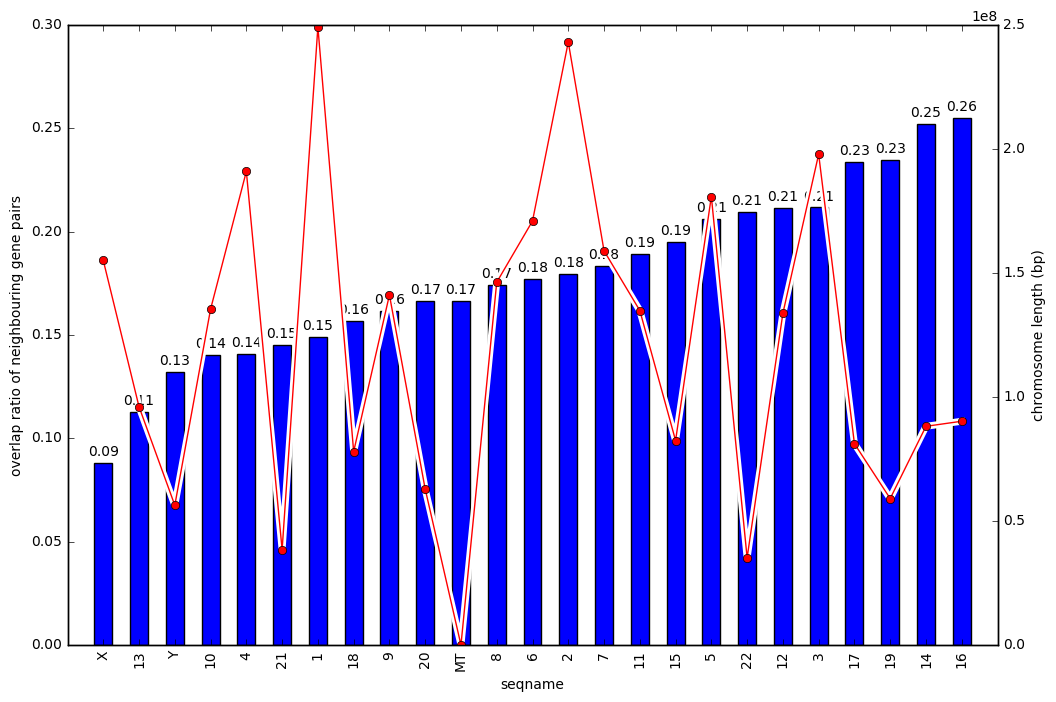

In [56]:
ax = df_overlap.overlap_ratio.plot.bar(figsize=(12, 8))
ax2 = ax.twinx()

ax.set_xlabel('seqname')
ax.set_ylabel('overlap ratio of neighbouring gene pairs')

df_overlap['len'].plot(ax=ax2, lw=5, color='white')
df_overlap['len'].plot(ax=ax2, lw=1, marker='o', color='red')
ax2.set_ylabel('chromosome length (bp)')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height() + 0.002,
                '{0:.2f}'.format(p.get_height()),
                ha='center', va='bottom')

ax.set_xlim(-1, 25)

In [57]:
df_overlap.sort_values('overlap_ratio')

,overlap_ratio,len
seqname,,
X,0.088058,155087438
13,0.112805,96058111
Y,0.132075,56348845
10,0.140260,135425372
4,0.140992,190964728
21,0.145228,38427966
1,0.148916,249219373
18,0.156794,77994326
9,0.161692,141138161


### look at one chr a time, for debugging purpose

In [66]:
chrdf = subdf.query('seqname == "1"').sort_values('start')

In [67]:
assert chrdf.shape == (2076, 12)

In [68]:
chrdf.head(10)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
109,1,protein_coding,gene,69091,70008,.,+,.,918,,ENSG00000186092,OR4F5
140,1,protein_coding,gene,134901,139379,.,-,.,4479,,ENSG00000237683,AL627309.1
276,1,protein_coding,gene,367640,368634,.,+,.,995,,ENSG00000235249,OR4F29
373,1,protein_coding,gene,621059,622053,.,-,.,995,,ENSG00000185097,OR4F16
510,1,protein_coding,gene,738532,739137,.,-,.,606,,ENSG00000269831,AL669831.1
605,1,protein_coding,gene,818043,819983,.,+,.,1941,,ENSG00000269308,AL645608.2
637,1,protein_coding,gene,860260,879955,.,+,.,19696,,ENSG00000187634,SAMD11
756,1,protein_coding,gene,861264,866445,.,-,.,5182,,ENSG00000268179,AL645608.1
771,1,protein_coding,gene,879584,894689,.,-,.,15106,,ENSG00000188976,NOC2L
853,1,protein_coding,gene,895967,901095,.,+,.,5129,,ENSG00000187961,KLHL17


In [69]:
gene_names = chrdf.gene_name.values

In [73]:
# For each gene but the first and last, create a pair of placeholders for start and end
gn_pairs = np.concatenate([
    gene_names[0:1], 
    np.repeat(gene_names[1:-1], 2), 
    gene_names[-1:]
]).reshape(-1, 2)

In [74]:
assert gn_pairs.shape == (2075, 2)

In [75]:
# pairs of (end_of_1st_gene, start_of_next_gene)
endstart = chrdf[['start', 'end']].values.ravel()[1:-1].reshape(-1, 2)

In [76]:
endstart_df = pd.DataFrame(endstart, columns=['gene1_end', 'gene2_start'])

In [78]:
assert endstart_df.shape == (2075, 2)

In [79]:
endstart_df['gene1'] = gn_pairs[:,0]

In [80]:
endstart_df['gene2'] = gn_pairs[:,1]

In [82]:
endstart_df['diff'] = endstart_df.gene2_start - endstart_df.gene1_end

In [85]:
endstart_df.head(2)

,gene1_end,gene2_start,gene1,gene2,diff
0,70008,134901,OR4F5,AL627309.1,64893
1,139379,367640,AL627309.1,OR4F29,228261


In [86]:
endstart_df['has_overlap'] = endstart_df.apply(lambda row: row['diff'] < 0, axis=1)

In [87]:
endstart_df.head(2)

,gene1_end,gene2_start,gene1,gene2,diff,has_overlap
0,70008,134901,OR4F5,AL627309.1,64893,False
1,139379,367640,AL627309.1,OR4F29,228261,False


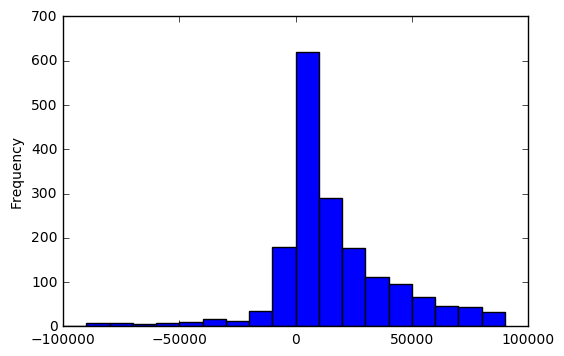

In [90]:
endstart_df['diff'].plot.hist(bins=np.arange(-1e5, 1e5, 1e4), figsize=(6, 4))

In [91]:
assert chrdf.shape == (2076, 12)

In [92]:
assert endstart_df.shape == (2075, 6)

In [94]:
endstart_df.head(2)

,gene1_end,gene2_start,gene1,gene2,diff,has_overlap
0,70008,134901,OR4F5,AL627309.1,64893,False
1,139379,367640,AL627309.1,OR4F29,228261,False


In [95]:
overlapped_gene_pairs = endstart_df.query('diff < 0')['diff'].shape[0] 
assert overlapped_gene_pairs == 309

In [97]:
all_gene_pairs = endstart_df.shape[0]

In [98]:
assert overlapped_gene_pairs / all_gene_pairs == 0.1489156626506024

So ~15% of genes overlap, that's quite a bit